In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader, TensorDataset
sd = 42
random.seed(sd)
np.random.seed(sd)
torch.manual_seed(sd)
# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义模型
class AngleClassifier(nn.Module):
    def __init__(self):
        super(AngleClassifier, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 12)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
def independent_roll(mat, rolls):
    """Roll for each rows"""
    output = list(map(torch.roll, torch.unbind(mat, 0), rolls.tolist()))
    output = torch.stack(output, 0)
    return output
class DAL(nn.Module):
    def __init__(self):
        super(DAL, self).__init__()
        self.dir_weight = torch.tensor(
            [0.        , 0.25881905, 0.5       , 0.70710678, 0.8660254 ,
       0.96592583, 1.        , 0.96592583, 0.8660254 , 0.70710678,
       0.5       , 0.25881905],
            requires_grad=False,
        )
        self.dir_weight = self.dir_weight*12 / torch.sum(self.dir_weight)
    def forward(self, pred, label):
        bs = pred.shape[0]
        dal_weight = self.dir_weight.unsqueeze(0).repeat(bs,1).to(pred.device)
        dal_weight = independent_roll(dal_weight, label)
        pred_weighted = dal_weight*torch.softmax(pred, dim=1)
        loss1 = pred_weighted.sum(dim=1).mean()
        loss2 = F.cross_entropy(pred, label)
        loss = loss1*0.5+loss2*0.5
        return loss, loss1.detach(), loss2.detach()
        

# 生成随机训练数据和测试数据
def generate_data(num_samples):
    cx = 2
    cy = 4
    R = 3
    theta = np.random.rand(num_samples)*2*np.pi
    radius = np.random.rand(num_samples)*R
    x = cx+radius*np.cos(theta)
    y = cy+radius*np.sin(theta)
    coords = np.stack((x,y), axis=1)
    angles = np.arctan2(coords[:, 1] - cy, coords[:, 0] - cx) * 180 / np.pi
    angles = (angles + 360) % 360
    labels = (angles // 30).astype(int)
    return coords, labels

# 数据生成
train_coords, train_labels = generate_data(1000)
test_coords, test_labels = generate_data(200)

# 转换为Tensor并创建DataLoader
train_coords = torch.tensor(train_coords, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_coords = torch.tensor(test_coords, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_coords, train_labels)
test_dataset = TensorDataset(test_coords, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义两种损失函数
criterion_standard = nn.CrossEntropyLoss()
criterion_weighted = DAL()

# 训练模型函数
def train_model(criterion, num_epochs=50):
    model = AngleClassifier().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_coords, batch_labels in train_loader:
            batch_coords, batch_labels = batch_coords.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_coords)
            loss = criterion(outputs, batch_labels)
            if isinstance(loss, tuple):
                loss[0].backward()
                optimizer.step()
                epoch_loss += loss[2].item()
            else:
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        correct = 0
        total = 0
        epoch_loss = 0.0
        with torch.no_grad():
            for batch_coords, batch_labels in test_loader:
                batch_coords, batch_labels = batch_coords.to(device), batch_labels.to(device)
                outputs = model(batch_coords)
                loss = criterion(outputs, batch_labels)
                if isinstance(loss, tuple):
                    epoch_loss += loss[2].item()
                else:
                    epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
        test_losses.append(epoch_loss / len(test_loader))
        accuracy = correct / total
        test_accuracies.append(accuracy)

        # print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Test Accuracy: {accuracy:.4f}")

    return train_losses, test_losses, test_accuracies

# 训练模型并获取结果
train_losses_standard, test_losses_standard, test_accuracies_standard = train_model(criterion_standard)
train_losses_weighted, test_losses_weighted, test_accuracies_weighted = train_model(criterion_weighted)

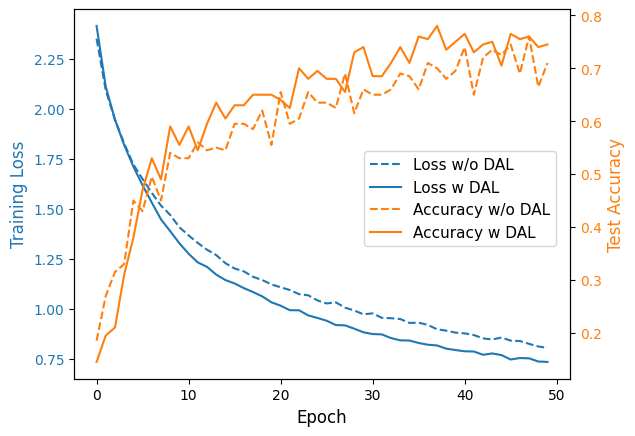

In [119]:
# 可视化训练损失曲线和测试准确率
# fig, ax1 = plt.subplots()
plt.figure()
ax1 = plt.gca()

color = 'tab:blue'
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', color=color, fontsize=12)
ax1.plot(train_losses_standard, label='Loss w/o DAL', linestyle='--', color=color)
ax1.plot(train_losses_weighted, label='Loss w DAL', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Test Accuracy', color=color, fontsize=12)
ax2.plot(test_accuracies_standard, label='Accuracy w/o DAL', linestyle='--', color=color)
ax2.plot(test_accuracies_weighted, label='Accuracy w DAL', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig = plt.gcf()
# fig.tight_layout()
fig.legend(loc="upper right",bbox_to_anchor=(0.89, 0.6), fontsize=11)
# plt.title('Coordinate-to-Direction Prediction')
plt.savefig("6-c.jpg", dpi=600, pil_kwargs={'quality': 100}, bbox_inches="tight")
plt.show()

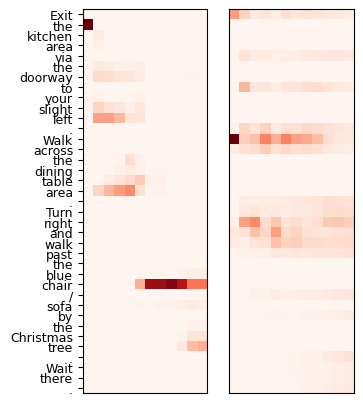

In [186]:
import spacy
def softmax(x, axis=1, temp=1.0):
    x = x / temp
    # x -= np.max(x, axis= axis, keepdims=True)
    f_x = np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims=True)
    return f_x
nlp = spacy.load("en_core_web_sm")

map1 = np.load("/share/home/tj90055/hzt/IA-HWP/logs/iaw_train0_ckpt5_map1.npy")
map2 = np.load("/share/home/tj90055/hzt/IA-HWP/logs/iaw_train0_ckpt5_map2.npy")
map1 = softmax(np.log(map1+1e-8), axis=0)
map2 = softmax(np.log(map2+1e-8), axis=0)
text="Exit the kitchen area via the doorway to your slight left. Walk across the dining table area. Turn right and walk past the blue chair/sofa by the Christmas tree. Wait there. "
figsize=(2.5,2.5)
cmap='Reds'
doc = nlp(text)
labels = [v.text for v in doc]
fig, axs = plt.subplots(1,2)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=-0.6, hspace=0.1)
ax = axs[0]
ax2= axs[1]
ax.set_xticks([])
ax.set_xticks([], minor=True)
ax.set_yticks(list(range(len(labels))))
ax.set_yticklabels(labels, fontsize=9)
pcm = ax.imshow(map1, cmap=cmap)

ax2.set_xticks([])
ax2.set_xticks([], minor=True)
ax2.set_yticks([])
ax2.set_yticks([], minor=True)
pcm2 = ax2.imshow(map2, cmap=cmap)
# fig.tight_layout()
fig.savefig('vis_0_5.svg', bbox_inches="tight", dpi=600)
plt.show()
plt.close()